<a href="https://colab.research.google.com/github/ymuto0302/PJ2025/blob/main/early_stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## early stopping

Using device: cpu


100%|██████████| 170M/170M [00:01<00:00, 99.5MB/s]


Training samples: 8000
Validation samples: 2000
Test samples: 10000
Starting training...
Epoch   1: Train Loss: 1.8209, Train Acc: 30.89%, Val Loss: 12.1916, Val Acc: 0.00%
Epoch   2: Train Loss: 1.5325, Train Acc: 42.83%, Val Loss: 10.9537, Val Acc: 0.00%
Epoch   3: Train Loss: 1.4040, Train Acc: 47.24%, Val Loss: 10.5422, Val Acc: 0.00%
Epoch   4: Train Loss: 1.3283, Train Acc: 50.49%, Val Loss: 11.0088, Val Acc: 0.00%
Epoch   5: Train Loss: 1.2378, Train Acc: 54.01%, Val Loss: 11.3691, Val Acc: 0.00%
Epoch   6: Train Loss: 1.1979, Train Acc: 56.17%, Val Loss: 11.9937, Val Acc: 0.00%
Epoch   7: Train Loss: 1.1614, Train Acc: 57.46%, Val Loss: 14.4157, Val Acc: 0.00%
Epoch   8: Train Loss: 1.1080, Train Acc: 59.60%, Val Loss: 13.4482, Val Acc: 0.00%
Epoch   9: Train Loss: 1.0468, Train Acc: 61.67%, Val Loss: 12.8157, Val Acc: 0.00%
Epoch  10: Train Loss: 0.9963, Train Acc: 63.23%, Val Loss: 14.0203, Val Acc: 0.00%
Epoch  11: Train Loss: 0.9820, Train Acc: 64.19%, Val Loss: 13.7484, Va

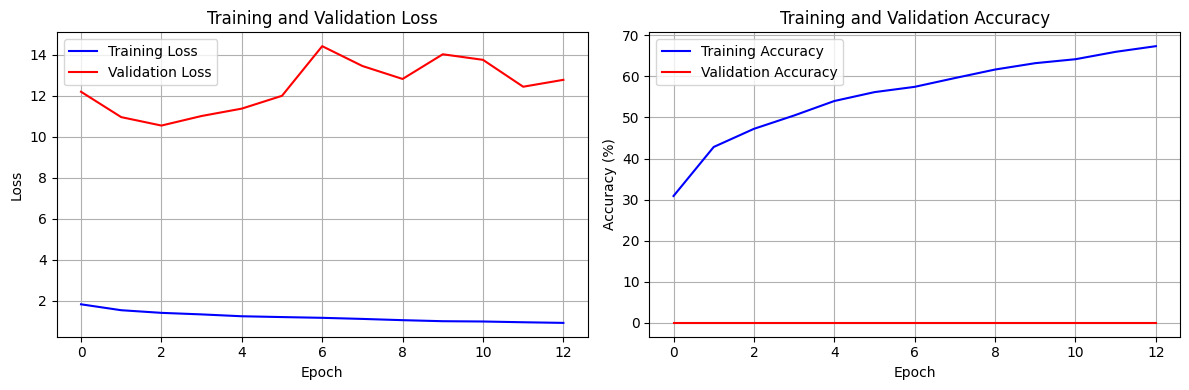

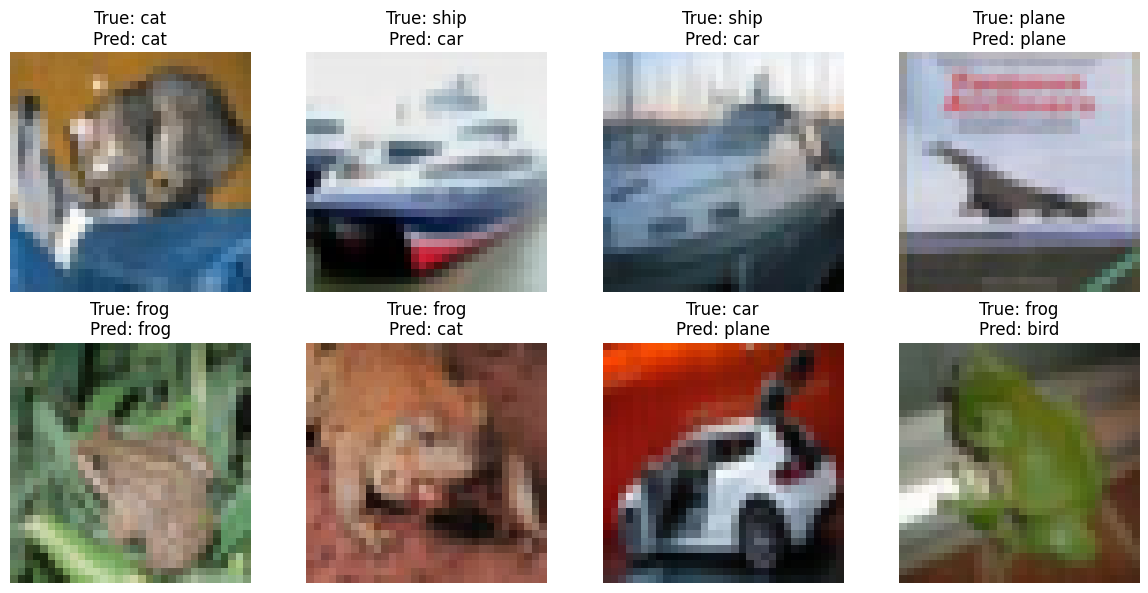


=== 実験結果まとめ ===
使用したデータ: CIFAR-10の20%（8000サンプル）
最終テスト精度: 53.02%
早期停止により訓練を13エポックで終了


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# データの前処理
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10データセットの読み込み
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)

# サブセットの作成（元のデータの20%を使用）
subset_ratio = 0.2
num_train_samples = int(len(full_trainset) * subset_ratio)

# 各クラスから均等にサンプルを取得
def create_balanced_subset(dataset, num_samples):
    """各クラスから均等にサンプルを取得してサブセットを作成"""
    class_indices = {i: [] for i in range(10)}  # CIFAR-10は10クラス

    # 各クラスのインデックスを収集
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # 各クラスから均等にサンプリング
    samples_per_class = num_samples // 10
    selected_indices = []

    for class_idx in range(10):
        class_samples = random.sample(class_indices[class_idx],
                                    min(samples_per_class, len(class_indices[class_idx])))
        selected_indices.extend(class_samples)

    return selected_indices

# バランスの取れたサブセットのインデックスを取得
random.seed(42)  # 再現性のため
subset_indices = create_balanced_subset(full_trainset, num_train_samples)

# サブセットの作成
trainset = Subset(full_trainset, subset_indices)

# 訓練データをさらに訓練用と検証用に分割
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(trainset)))

train_subset = Subset(trainset, train_indices)
val_subset = Subset(trainset, val_indices)

# データローダーの作成
batch_size = 64
trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Training samples: {len(train_subset)}')
print(f'Validation samples: {len(val_subset)}')
print(f'Test samples: {len(testset)}')

# CNNモデルの定義
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 早期停止クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

# モデル、損失関数、最適化器の設定
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 早期停止の設定
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# 訓練履歴を記録するリスト
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 訓練ループ
def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, early_stopping, epochs=100):
    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += targets.size(0)
            correct_train += predicted.eq(targets).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct_train / total_train

        # 検証フェーズ
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += targets.size(0)
                correct_val += predicted.eq(targets).sum().item()

        val_loss /= len(valloader)
        val_acc = 100. * correct_val / total_val

        # 履歴の記録
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # 学習率スケジューラーの更新
        scheduler.step()

        print(f'Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # 早期停止の判定
        if early_stopping(val_loss, model):
            print(f'Early stopping at epoch {epoch+1}')
            break

    return model

# モデルの訓練
print("Starting training...")
model = train_model(model, trainloader, valloader, criterion, optimizer, scheduler, early_stopping)

# テストデータでの評価
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss /= len(testloader)
    test_acc = 100. * correct / total

    print(f'\nTest Results:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.2f}%')

    return test_acc, test_loss

# テスト評価
test_accuracy, test_loss = evaluate_model(model, testloader)

# 結果の可視化
def plot_training_history():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 損失の推移
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 精度の推移
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 訓練履歴の可視化
plot_training_history()

# CIFAR-10のクラス名
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# サンプル画像の予測結果表示
def show_predictions(model, testloader, num_images=8):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # 画像の表示
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_images):
        img = images[i].cpu()
        # 正規化を元に戻す
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        axes[i].imshow(img)
        axes[i].set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 予測結果の表示
show_predictions(model, testloader)

print(f"\n=== 実験結果まとめ ===")
print(f"使用したデータ: CIFAR-10の{subset_ratio*100:.0f}%（{len(train_subset)}サンプル）")
print(f"最終テスト精度: {test_accuracy:.2f}%")
print(f"早期停止により訓練を{len(train_losses)}エポックで終了")

### データセットをフル活用

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

In [ ]:
# データの前処理
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10データセット全体の読み込み
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)

# 訓練データを訓練用と検証用に分割（全データの80%を訓練用、20%を検証用）
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size

# 再現性のためのシード設定
torch.manual_seed(42)
train_dataset, val_dataset = random_split(full_trainset, [train_size, val_size])

print(f'Full training samples: {len(full_trainset)}')
print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(testset)}')

# データローダーの作成
batch_size = 128  # フルデータセット用にバッチサイズを大きく設定
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# CNNモデルの定義
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ImprovedCNN, self).__init__()

        # 第1ブロック
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # 第2ブロック
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # 第3ブロック
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # 第4ブロック
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # 全結合層
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # 第1ブロック
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.bn1(x)
        x = self.pool(x)

        # 第2ブロック
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.bn2(x)
        x = self.pool(x)

        # 第3ブロック
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.bn3(x)
        x = self.pool(x)

        # 第4ブロック
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.bn4(x)
        x = self.pool(x)

        # Global Average Pooling
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # 全結合層
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# 早期停止クラス
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

In [ ]:
# モデル、損失関数、最適化器の設定
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# コサインアニーリングスケジューラー（フルデータセット用に適したスケジューラー）
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# 早期停止の設定（フルデータセット用にpatienceを増加）
early_stopping = EarlyStopping(patience=15, min_delta=0.001)

Using device: cuda
Full training samples: 50000
Training samples: 40000
Validation samples: 10000
Test samples: 10000
Starting training with full CIFAR-10 dataset...
This may take a while depending on your hardware...
Epoch   1: Train Loss: 1.5815, Train Acc: 41.88%, Val Loss: 1.4347, Val Acc: 48.94%, Best Val Acc: 48.94%, LR: 0.000999
Epoch   2: Train Loss: 1.1490, Train Acc: 59.35%, Val Loss: 1.0311, Val Acc: 63.00%, Best Val Acc: 63.00%, LR: 0.000996
Epoch   3: Train Loss: 0.9445, Train Acc: 67.40%, Val Loss: 0.8624, Val Acc: 69.17%, Best Val Acc: 69.17%, LR: 0.000991
Epoch   4: Train Loss: 0.8094, Train Acc: 72.47%, Val Loss: 0.7367, Val Acc: 74.50%, Best Val Acc: 74.50%, LR: 0.000984
Epoch   5: Train Loss: 0.7287, Train Acc: 75.39%, Val Loss: 0.7330, Val Acc: 74.60%, Best Val Acc: 74.60%, LR: 0.000976
Epoch   6: Train Loss: 0.6607, Train Acc: 77.31%, Val Loss: 0.6850, Val Acc: 76.14%, Best Val Acc: 76.14%, LR: 0.000965
Epoch   7: Train Loss: 0.6159, Train Acc: 79.35%, Val Loss: 0.

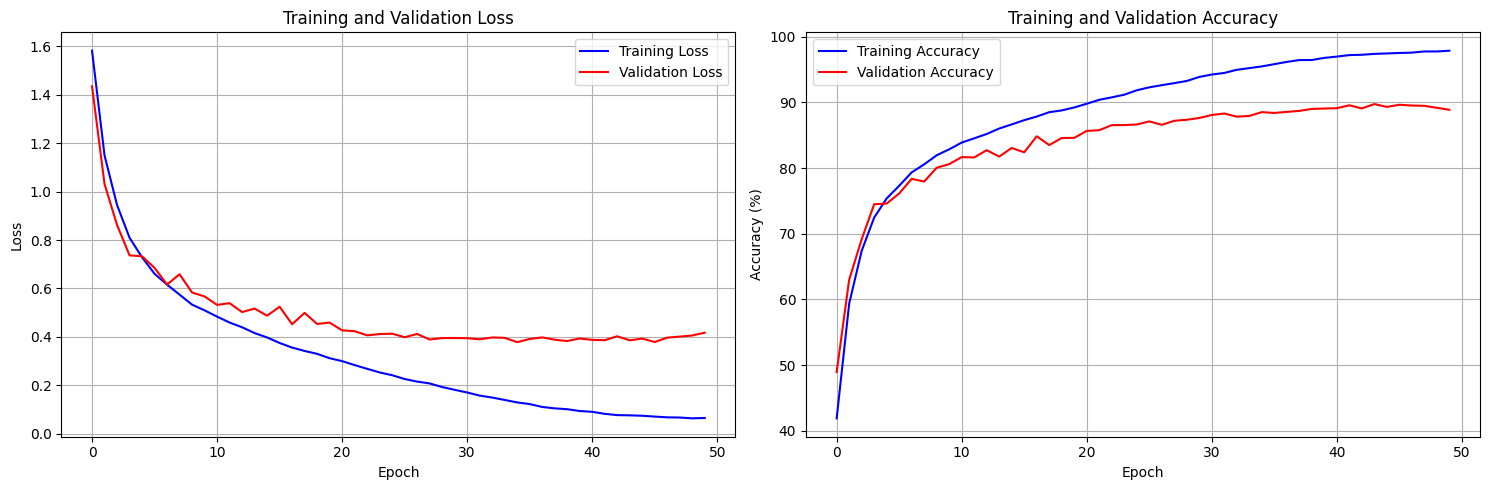

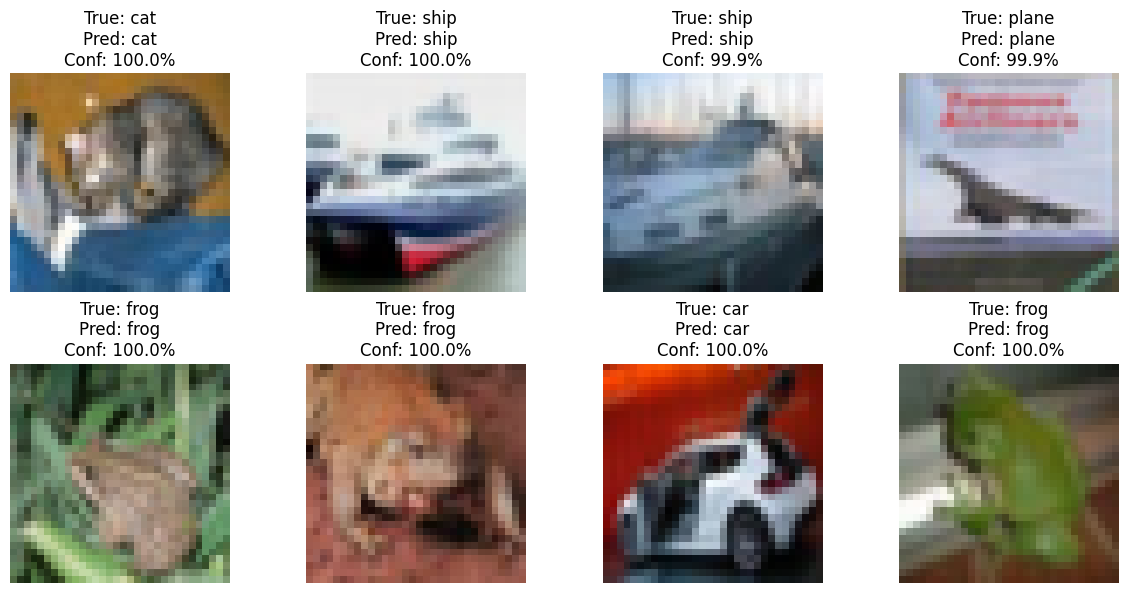

Model saved as 'cifar10_full_model.pth'

=== 実験結果まとめ ===
使用したデータ: CIFAR-10全データセット（40000サンプル訓練用）
最終テスト精度: 90.97%
訓練エポック数: 50エポック
使用モデル: 改良版CNN（4ブロック、BatchNorm付き）


In [2]:
# 訓練履歴を記録するリスト
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 訓練ループ
def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, early_stopping, epochs=200):
    best_val_acc = 0.0

    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += targets.size(0)
            correct_train += predicted.eq(targets).sum().item()

            '''
            # プログレス表示（大きなデータセットのため）
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(trainloader)}, '
                      f'Loss: {loss.item():.4f}')
            '''

        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct_train / total_train

        # 検証フェーズ
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in valloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total_val += targets.size(0)
                correct_val += predicted.eq(targets).sum().item()

        val_loss /= len(valloader)
        val_acc = 100. * correct_val / total_val

        # 履歴の記録
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # 学習率スケジューラーの更新
        scheduler.step()

        # 最高精度の更新
        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f'Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
              f'Best Val Acc: {best_val_acc:.2f}%, LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # 早期停止の判定
        if early_stopping(val_loss, model):
            print(f'Early stopping at epoch {epoch+1}')
            print(f'Best validation accuracy: {best_val_acc:.2f}%')
            break

    return model

# モデルの訓練
print("Starting training with full CIFAR-10 dataset...")
print("This may take a while depending on your hardware...")
model = train_model(model, trainloader, valloader, criterion, optimizer, scheduler, early_stopping)

# テストデータでの評価
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # クラス別精度の計算
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_loss /= len(testloader)
    test_acc = 100. * correct / total

    print(f'\nTest Results:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.2f}%')

    # クラス別精度の表示
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    print(f'\nClass-wise Accuracy:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')

    return test_acc, test_loss

# テスト評価
test_accuracy, test_loss = evaluate_model(model, testloader)

# 結果の可視化
def plot_training_history():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 損失の推移
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 精度の推移
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 訓練履歴の可視化
plot_training_history()

# CIFAR-10のクラス名
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# サンプル画像の予測結果表示
def show_predictions(model, testloader, num_images=8):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # 画像の表示
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_images):
        img = images[i].cpu()
        # 正規化を元に戻す
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        confidence = probabilities[i][predicted[i]].item() * 100

        axes[i].imshow(img)
        axes[i].set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}\nConf: {confidence:.1f}%')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 予測結果の表示
show_predictions(model, testloader)

# モデルの保存
torch.save(model.state_dict(), 'cifar10_full_model.pth')
print("Model saved as 'cifar10_full_model.pth'")

print(f"\n=== 実験結果まとめ ===")
print(f"使用したデータ: CIFAR-10全データセット（{len(train_dataset)}サンプル訓練用）")
print(f"最終テスト精度: {test_accuracy:.2f}%")
print(f"訓練エポック数: {len(train_losses)}エポック")
print(f"使用モデル: 改良版CNN（4ブロック、BatchNorm付き）")